# 🤖 Modelagem de Vendas Diárias com Prophet

---

### 📝 Objetivo

Nesta etapa, vamos criar um modelo de **previsão de vendas diárias** utilizando a biblioteca **Prophet**.  

O objetivo é:  
- Capturar padrões históricos de vendas.  
- Prever valores futuros para auxiliar na tomada de decisão.  
- Avaliar o desempenho do modelo usando métricas como **RMSE** e **MAPE**.  
- Visualizar tendências e intervalos de confiança das previsões.

---

### 🔹 Etapas do Pipeline

1. **Pré-processamento dos dados**  
   - Filtragem de vendas positivas (`valor_total > 0`).  
   - Tratamento de outliers usando **Winsorize** ou **IQR**.  
   - Transformação logarítmica para reduzir impacto de picos extremos.  

2. **Divisão treino/teste**  
   - Treino: todos os dados históricos **exceto os últimos 30 dias**.  
   - Teste: últimos 30 dias.  

3. **Criação do modelo Prophet**  
   - Sazonalidades: diária, semanal, mensal e anual.  
   - Inclusão de feriados do Brasil.  
   - Intervalo de confiança de 95%.  

4. **Treinamento e previsão**  
   - Ajuste do modelo nos dados de treino.  
   - Previsão para o período de teste e para os próximos 30 dias.  
   - Transformação de volta da escala logarítmica para valores reais.  

5. **Avaliação do modelo**  
   - Cálculo de **RMSE** e **MAPE** para medir precisão.  
   - Visualização das previsões versus valores reais com intervalos de confiança.  

---

### 🔹 Observações

- O log-transform é importante para reduzir o efeito de picos extremos em vendas.  
- A inclusão de sazonalidades múltiplas permite ao modelo capturar padrões diários, semanais e mensais.  
- As métricas de avaliação ajudam a entender a qualidade da previsão e identificar possíveis ajustes.  


In [397]:

#Importando bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [398]:
# Carregando dados

dados = pd.read_csv('../raw/dados_tratados.csv')

In [399]:
# Filtrando dados para vendas positivas

dados = dados[dados['valor_total'] > 0].copy()

In [400]:
# Garantindo datetime
dados['data_fatura'] = pd.to_datetime(dados['data_fatura'])

In [402]:
# Agrupamento diario

vendas_diarias = (
    dados.groupby(dados['data_fatura'].dt.date)['valor_total']
    .sum()
    .reset_index()
)
vendas_diarias.columns = ['ds', 'y']
vendas_diarias['ds'] = pd.to_datetime(vendas_diarias['ds'])

In [403]:
#Tratamento de outliers mais robusto (Winsorize)
from scipy.stats.mstats import winsorize

# Aplicar Winsorize 1% e 99%
vendas_diarias['y_wins'] = winsorize(vendas_diarias['y'], limits=[0.01, 0.01])

# Log-transform
vendas_diarias['y_log'] = np.log1p(vendas_diarias['y_wins'])

In [404]:
# Divisão Treino/Teste

treino = vendas_diarias[:-30].copy()
teste = vendas_diarias[-30:].copy()


In [406]:
# Criação e Treinamento do Modelo
modelo = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.1,   # mais conservador
    interval_width=0.95
)

# Sazonalidade mensal
modelo.add_seasonality(name='mensal', period=30.5, fourier_order=5)

# Feriados do Brasil
modelo.add_country_holidays(country_name='BR')

# Treinar modelo usando log-transform
modelo.fit(treino[['ds','y_log']].rename(columns={'y_log':'y'}))

21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing


In [407]:
# Criando datas futuras e prevendo
futuro = modelo.make_future_dataframe(periods=30)
previsao = modelo.predict(futuro)

# Transformar de volta para escala original
previsao['yhat_orig'] = np.expm1(previsao['yhat'])
previsao['yhat_lower_orig'] = np.expm1(previsao['yhat_lower'])
previsao['yhat_upper_orig'] = np.expm1(previsao['yhat_upper'])

In [408]:
# Avaliação do Modelo
previsao_teste = previsao.iloc[-30:]['yhat_orig'].values
y_true = teste['y'].values

rmse = np.sqrt(mean_squared_error(y_true, previsao_teste))
mape = mean_absolute_percentage_error(y_true, previsao_teste) * 100

print(f"RMSE no período de teste: {rmse:.2f}")
print(f"MAPE no período de teste: {mape:.2f}%")

RMSE no período de teste: 33097.63
MAPE no período de teste: 55.85%


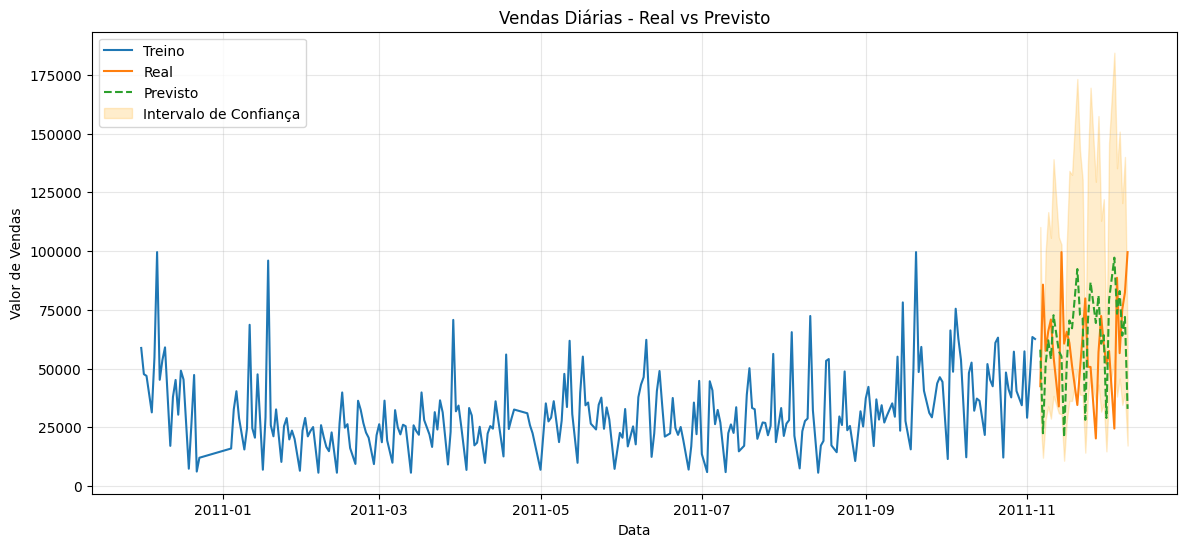

In [409]:
# Visualização
plt.figure(figsize=(14,6))

# Treino e teste
plt.plot(treino['ds'], treino['y'], label='Treino')
plt.plot(teste['ds'], teste['y'], label='Real')

# Previsão
plt.plot(teste['ds'], previsao_teste, label='Previsto', linestyle='--')

# Intervalo de confiança
plt.fill_between(
    teste['ds'],
    previsao.iloc[-30:]['yhat_lower_orig'],
    previsao.iloc[-30:]['yhat_upper_orig'],
    color='orange',
    alpha=0.2,
    label='Intervalo de Confiança'
)

plt.title('Vendas Diárias - Real vs Previsto')
plt.xlabel('Data')
plt.ylabel('Valor de Vendas')
plt.legend()
plt.grid(alpha=0.3)
plt.show()